# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x + \beta_2z + \beta_2*\beta_3$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [ ]:
import numpy as np
# Receive dataframe from Preprocessing
%store -r pre_df

pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

train_df = pre_df.sample(frac=0.8, random_state=1863)
test_df = pre_df.drop(train_df.index)

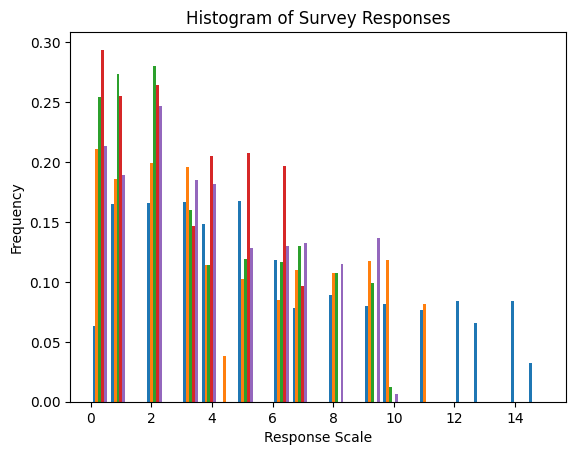

In [51]:
import matplotlib.pyplot as plt
columns = train_df[
    ["Friends_circle_size", "Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
]

# TODO: Break out histogram of columns into subplots to see which are normally distributed.

plt.hist(columns, bins=25, density=True)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")

plt.show()

In [52]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

In [53]:
import numpy as np
import pandas as pd

# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

X = train_df[["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
display_side_by_side(B, residuals.head())


R-Squared: 0.6348024310834368


,Friends_circle_size
Time_spent_Alone,-0.249336
Post_frequency,0.217386
Going_outside,0.550913
Social_event_attendance,0.475484
Going_outside:Social_event_attendance,-0.017521
Intercept,3.343018
,Friends_circle_size
1385,-2.158513
320,-3.942537
37,1.183338


In [93]:
from statsmodels.formula.api import ols

standard_scaler = lambda x: x / max(x)
transformed_df = train_df.copy()

for column in [
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance"
]:
    # transformed_df[column] = standard_scaler(transformed_df[column])
    transformed_df[column] = transformed_df[column] / max(train_df[column])

# transformed_df = transformed_df[transformed_df["Personality"] == 0]  # Introvert

model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside + Social_event_attendance',
    data=transformed_df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     1005.
Date:                 Fri, 11 Jul 2025   Prob (F-statistic):               0.00
Time:                         08:47:09   Log-Likelihood:                -5472.2
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2315   BIC:                         1.098e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.5178      0.235     14.973      0.000       3.057       3.979
Time_spent_Alone           -2.7947      0.279    -10.034      0.000      -3.341      -2.249
Post_frequency              2.1949      0.316      6.952      0.000       1.576       2.814
Going_outside               3.3598      0.296     11.364      0.000       2.780       3.940
Social_event_attendance     4.1512      0.311     13.349      0.000       3.541       4.761
==============================================================================
Omnibus:                       32.134   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.529
Skew:                           0.260   Prob(JB):                     1.42e-07
Kurtosis:                       2.762   Cond. No.                         9.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
conf_intervals = model.conf_int()
conf_intervals

,0,1
Intercept,3.057136,3.978559
Time_spent_Alone,-3.340903,-2.248546
Post_frequency,1.575779,2.814072
Going_outside,2.780037,3.939546
Social_event_attendance,3.541347,4.761017


In [95]:
pred = model.get_prediction(test_df)
pred_summary = pred.summary_frame(alpha=0.05)

In [96]:
ci_lower = pred_summary['mean_ci_lower']
ci_upper = pred_summary['mean_ci_upper']
pi_lower = pred_summary['obs_ci_lower']
pi_upper = pred_summary['obs_ci_upper']

In [97]:
predictions = model.predict(test_df[['Time_spent_Alone', 'Post_frequency', 'Going_outside', 'Social_event_attendance']])

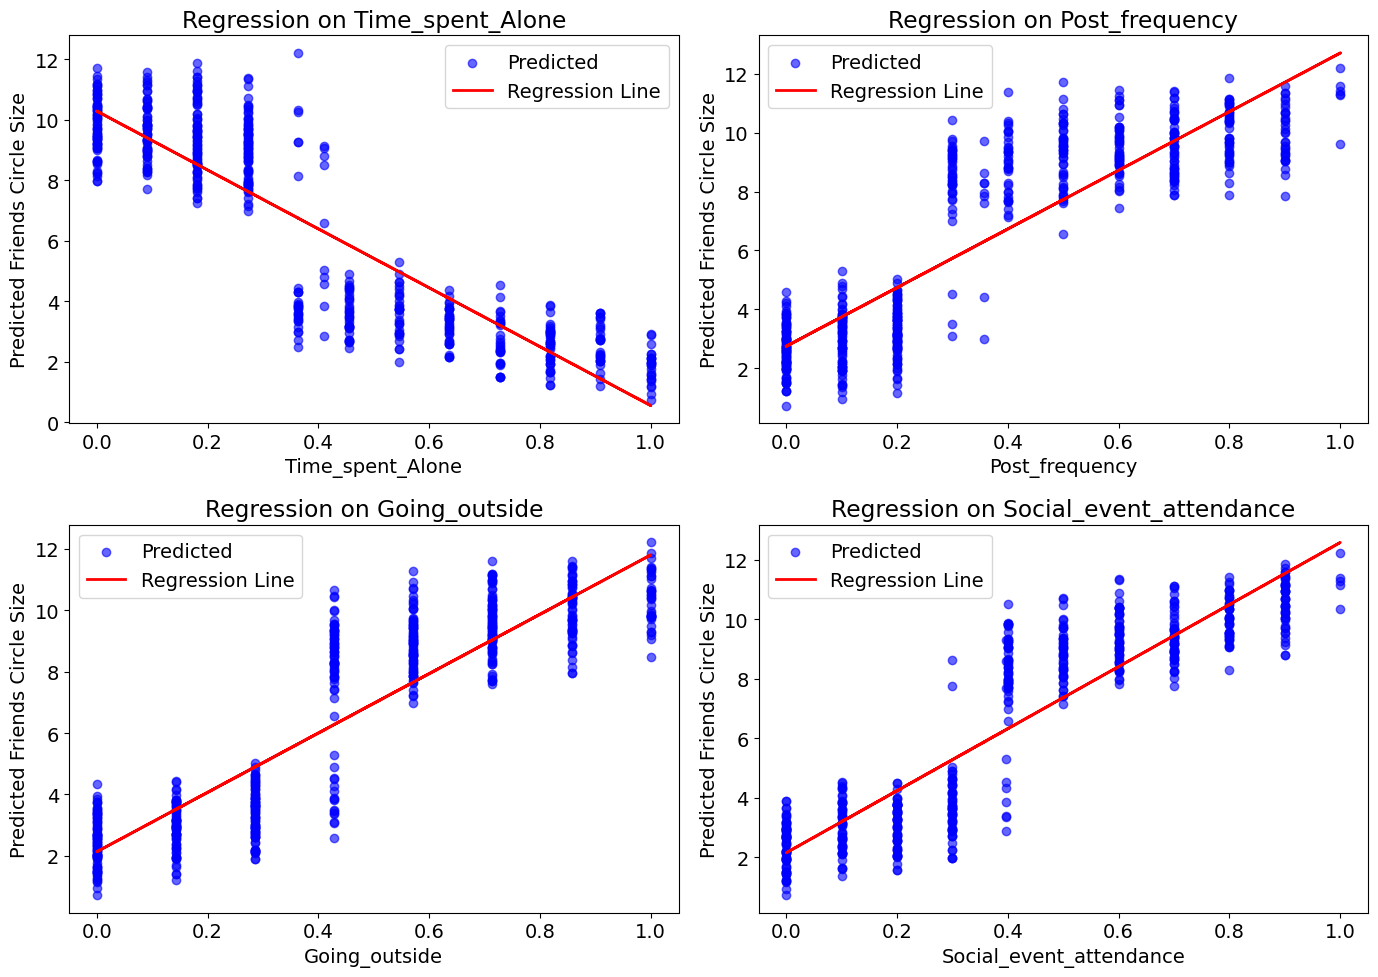

In [100]:
test_df_scaled = test_df.copy()
for column in [
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance"
]:
    test_df_scaled[column] = test_df_scaled[column] / max(test_df[column])

# Combine scaled test data with predictions
test_df_scaled['Predicted'] = model.predict(test_df_scaled)

# Define predictor variables
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Sort values for smooth line plotting
    sorted_df = test_df_scaled.sort_values(by=predictor)

    # Scatter plot of individual points
    x = test_df_scaled[predictor]
    y = test_df_scaled["Predicted"]
    ax.scatter(
        x=x,
        y=y,
        color="blue", alpha=0.6, label="Predicted"
    )

    # Smooth regression line showing the direction
    m, b = np.polyfit(x, y, 1)

    ax.plot(
        x,
        m * x + b,
        color="red", linewidth=2, label="Regression Line"
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

## Plot regression model

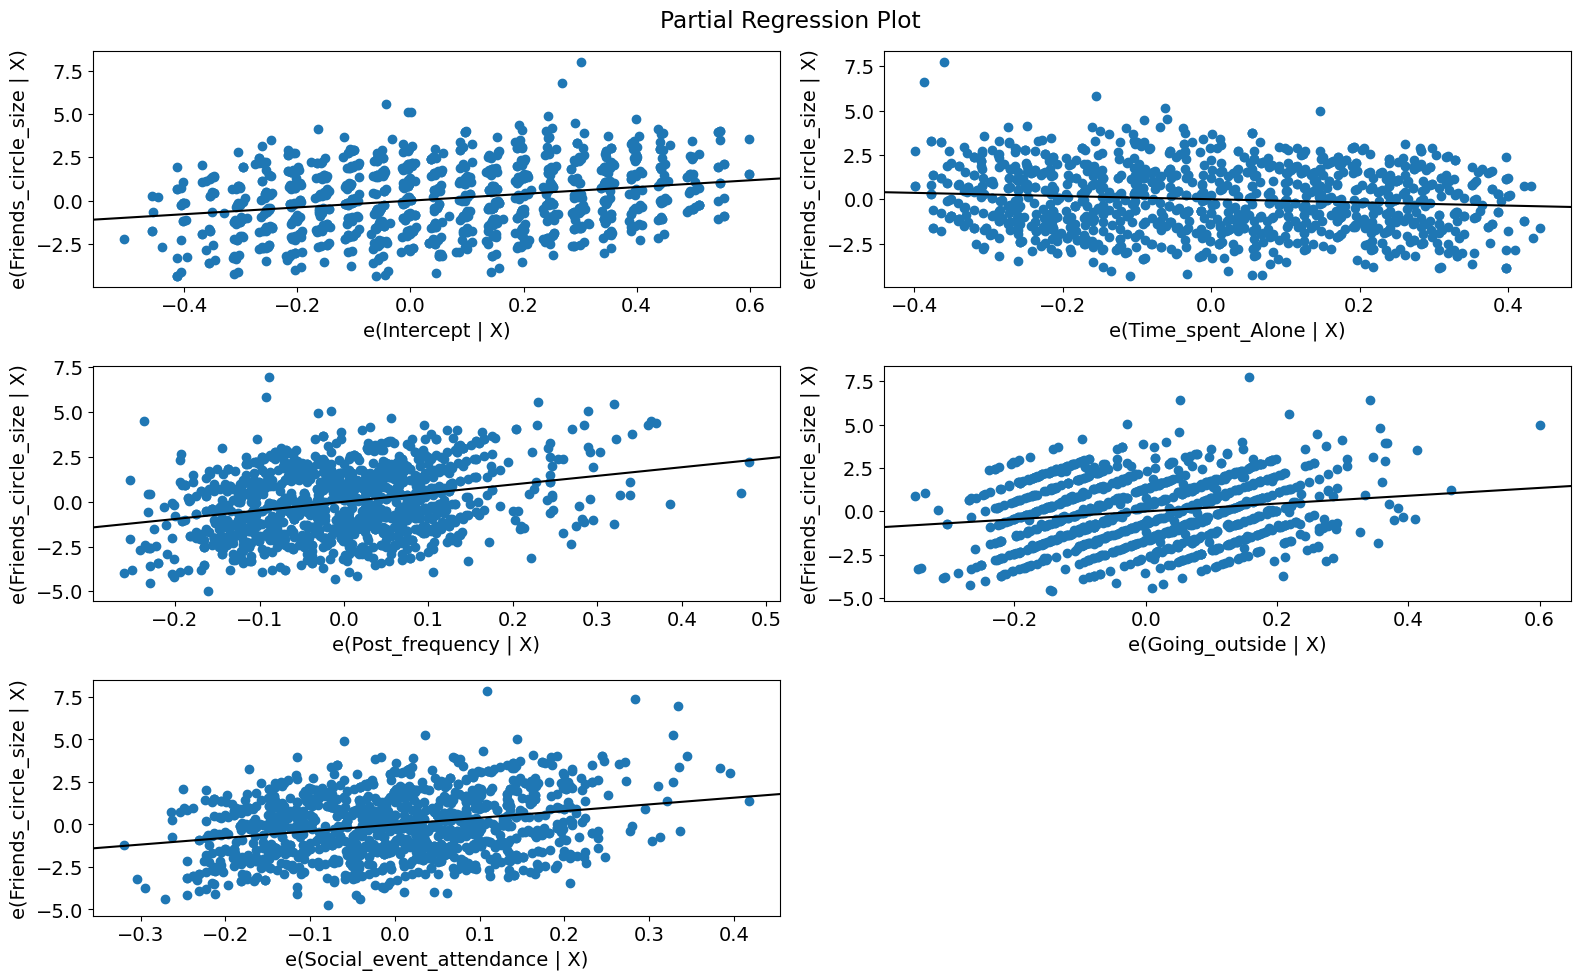

In [90]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(16, 10))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

### Determine Fitness of Residuals

c:\Users\Jared\Documents\R Projects\NeuralNetworkProject\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Residual standard error: 2.558343353486672


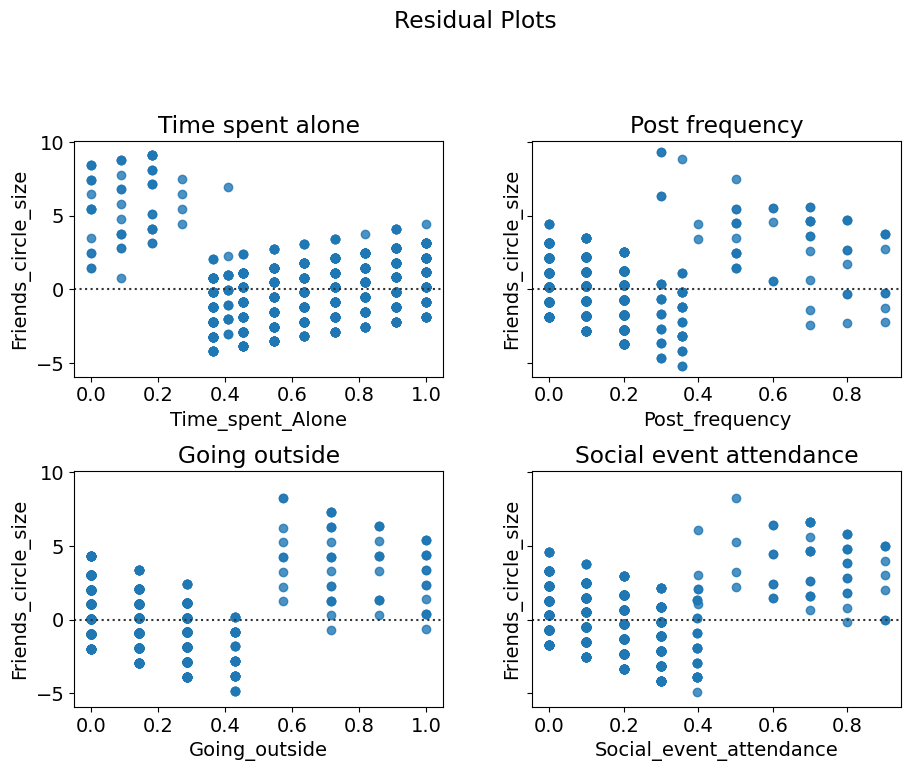

In [91]:
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals).iloc[0]))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position)
    position.set_title(plot["title"])


## Prediction

In [ ]:

time_alone = B.iloc[0]
post_freq = B.iloc[1]
outside = B.iloc[2]
events = B.iloc[3]
outside_events = B.iloc[4]

y = time_alone*4.0 + post_freq*1.0 + + outside*5.0 + events*7.0 + outside_events*4.0
y

Friends_circle_size    5.433735
dtype: float64